In [1]:
import ccxt
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os.path
from binance.client import Client
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm_notebook #(Optional, used for progress-bars)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
ERC20 = pd.read_csv('top500_erc20.txt', header=0, index_col=0)
ERC20 = list(ERC20.values.flatten())

In [3]:
len(ERC20)

500

In [4]:
folder_tokens = 'ERC20-1h-data'

def fetch_erc20(exchange):
    global ERC20
    exchange_markets = exchange.load_markets()
    
    fetched = {}
    for i in exchange_markets.keys():
        if (i.split('/')[0] in ERC20):
            if i.split('/')[1] not in fetched.keys():
                fetched[i.split('/')[1]] = [i]
            else:
                fetched[i.split('/')[1]].append(i)
        
    return fetched

def load_data_from_exchange(exchange, symbol, folder=folder_tokens):
    start_date = exchange.parse8601('2018-01-01T00:00:00')
    
    columns = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']
    candles = exchange.fetch_ohlcv(symbol, timeframe='1h', since=start_date)
    
    now_date = int(round(time.time()*1000))
    
    while True:
        try:
            if ((candles[-1][0]+1) > now_date):
                break
            candles += exchange.fetch_ohlcv(symbol, timeframe='1h', since=candles[-1][0]+1)
        except:
            break
    
    candles = np.array(candles)
    loaded_df = pd.DataFrame(data=candles, columns=columns)
    loaded_df['Timestamp'] = pd.to_datetime(loaded_df['Timestamp'], unit='ms')
    
    return loaded_df

### API

binance_api_key = 'lV5gbACM9yJOfRFbC54hAHGK00xwSKYuzdqYGA0dlm9yZ9zqMSfHoGL9vVmNiACS'    #Enter your own API-key here
binance_api_secret = open('ttt.txt', 'r').readlines()[0].split()[0] #Enter your own API-secret here

### CONSTANTS
binsizes = {"1m": 1, "5m": 5, "1h": 60, "1d": 1440}
batch_size = 750

binance_client = Client(api_key=binance_api_key, api_secret=binance_api_secret)


### FUNCTIONS
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.datetime.strptime('1 Jan 2018', '%d %b %Y')
    elif source == "bitmex": old = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=False).result()[0][0]['timestamp']
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    if source == "bitmex": new = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=True).result()[0][0]['timestamp']
    return old, new

def get_all_binance(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    if oldest_point == datetime.datetime.strptime('1 Jan 2017', '%d %b %Y'): print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else: print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: data_df = data
    data_df.set_index('timestamp', inplace=True)
    if save: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df


In [5]:
g_key = open('ttt.txt', 'r').readlines()[0].split()[0]

In [6]:
binance = ccxt.binance({
    'apiKey': 'lV5gbACM9yJOfRFbC54hAHGK00xwSKYuzdqYGA0dlm9yZ9zqMSfHoGL9vVmNiACS',
    'secret': g_key
})

huobi = ccxt.huobiru({
    'apiKey': 'ed2htwf5tf-1736dba7-4b6ef9e9-bc09a',
    'secret': '14852a8e-2e162b64-c9203682-bfb6d'
})

coinbase = ccxt.coinbase({
    'apiKey': 'koGdgKolXtIHdyfN',
    'secret': 'TC6AFXOgcqw97ye3L6c8u4CKlvdQECtt'
})

bittrex = ccxt.bittrex({
    'apiKey': '86083cb94a7440b69840acc1a48e32e0',
    'secret': '62a249de5d0c41849bdaba91ab615636'
})

kraken = ccxt.kraken({
    'apiKey': 'XIao0ASEXtQy0XAcnGEYWVsngL8Cgv9xO4LSsJCO3ITytPGTbI3KJe5r',
    'secret': 't0nVcP2K+d7bippTnW6wiIU2vRrHxD3wBCVAEQlKKDTIqIgGHklzsIRPPMLVVvIjv7lXL0BDyylvQ9jH1sqifg=='
})

bitmex = ccxt.bitmex({
    'apiKey': 'cX0XY59Apg5SuZkBzRmGMpXu',
    'secret': 't8_iTaOu6Rr7vdWRL2TZZgl83qwQRHJfVFuxn_fxC7lrukeo'
})

yobit = ccxt.yobit({
    'apiKey': '260DAE0198F21C4920DBA305BD3DAAE2',
    'secret': 'db191a392b1335ea305a36a051a8102e'
})



In [10]:
binance.fetch_ohlcv('BTC/USDT', '1m')

[[1585999500000, 6846.89, 6850.85, 6823.0, 6841.65, 180.698808],
 [1585999560000, 6841.65, 6841.65, 6831.0, 6834.17, 69.953958],
 [1585999620000, 6834.18, 6842.49, 6834.18, 6837.74, 41.438527],
 [1585999680000, 6836.49, 6838.94, 6834.03, 6834.22, 25.59513],
 [1585999740000, 6834.05, 6834.94, 6823.3, 6826.75, 111.849788],
 [1585999800000, 6826.75, 6831.0, 6825.03, 6830.14, 87.235299],
 [1585999860000, 6830.65, 6842.95, 6830.65, 6837.97, 50.075626],
 [1585999920000, 6838.72, 6840.21, 6835.41, 6837.0, 28.675021],
 [1585999980000, 6837.0, 6837.01, 6827.12, 6830.76, 64.187937],
 [1586000040000, 6830.88, 6834.0, 6827.08, 6833.96, 48.739951],
 [1586000100000, 6833.08, 6839.67, 6833.0, 6838.63, 28.523859],
 [1586000160000, 6838.63, 6839.07, 6834.04, 6836.63, 25.856867],
 [1586000220000, 6836.63, 6837.27, 6830.13, 6832.6, 22.875335],
 [1586000280000, 6832.87, 6832.87, 6826.0, 6826.01, 73.853951],
 [1586000340000, 6826.01, 6826.89, 6702.0, 6747.09, 1088.408898],
 [1586000400000, 6749.63, 6771.25

In [9]:
binance.iso8601(1586026800000)

'2020-04-04T19:00:00.000Z'

In [7]:
exchanges = [binance, bittrex, huobi, coinbase, kraken, bitmex, yobit]

In [8]:
candles_erc20 = []
exch_candle = {}

for exchange in exchanges:
    try:
        fetched = fetch_erc20(exchange)['BTC']
        exch_candle[exchange.__class__.__name__] = fetched
        candles_erc20 = np.union1d(candles_erc20, fetched)
    except:
        continue

In [9]:
for i in exch_candle.keys():
    print('{} has {} ERC20 tokens'.format(i, len(exch_candle[i])))

binance has 95 ERC20 tokens
bittrex has 93 ERC20 tokens
huobiru has 102 ERC20 tokens
kraken has 6 ERC20 tokens
yobit has 149 ERC20 tokens


In [11]:
binance_erc20 = exch_candle['binance']

In [12]:
%store binance_erc20

Stored 'binance_erc20' (list)


In [13]:
len(np.intersect1d(exch_candle['huobiru'], exch_candle['bittrex']))

32

In [71]:
def first_date(exchange):
    global exch_candle
    test = exch_candle[exchange.__class__.__name__][4]

    klines_exchange = exchange.fetch_ohlcv(test, timeframe='1h', since=exchange.parse8601('2018-01-01T00:00:00'))

    len(klines_exchange)

    print(exchange.iso8601(klines_exchange[0][0]))

In [72]:
first_date(kraken)

2020-03-03T14:00:00.000Z


In [15]:
bittrex.parse8601('2018-01-01T00:00:00')

1514764800000

In [19]:
a = 
for i in exch_candle['bittrex']:
    try:
        a = bittrex.fetch_ohlcv(i, timeframe='1h', since=1514764800000)
        break
    except:
        continue

In [20]:
a

[[1580392800000, 2.351e-05, 2.351e-05, 2.335e-05, 2.345e-05, 1583.00309759],
 [1580396400000, 2.342e-05, 2.354e-05, 2.342e-05, 2.352e-05, 423.71018338],
 [1580400000000, 2.357e-05, 2.37e-05, 2.336e-05, 2.336e-05, 17680.46913374],
 [1580403600000, 2.349e-05, 2.349e-05, 2.327e-05, 2.334e-05, 7402.01188711],
 [1580407200000, 2.328e-05, 2.34e-05, 2.32e-05, 2.324e-05, 18993.69000265],
 [1580410800000, 2.33e-05, 2.33e-05, 2.319e-05, 2.321e-05, 2994.19774946],
 [1580414400000, 2.323e-05, 2.344e-05, 2.323e-05, 2.34e-05, 6672.15728139],
 [1580418000000, 2.346e-05, 2.346e-05, 2.335e-05, 2.335e-05, 7121.2220018],
 [1580421600000, 2.335e-05, 2.339e-05, 2.324e-05, 2.334e-05, 10146.88258758],
 [1580425200000, 2.335e-05, 2.356e-05, 2.335e-05, 2.348e-05, 5419.40572681],
 [1580428800000, 2.341e-05, 2.36e-05, 2.341e-05, 2.36e-05, 93172.4633847],
 [1580432400000, 2.36e-05, 2.37e-05, 2.36e-05, 2.366e-05, 4245.04293978],
 [1580436000000, 2.368e-05, 2.368e-05, 2.358e-05, 2.358e-05, 26562.55168557],
 [158043

In [10]:
loaded_tokens = exch_candle['binance'].copy()

In [11]:
k = 1

klines_data_dict = {}

for i in list(exch_candle.keys())[1:]:
    for j in exch_candle[i]:
        if j not in loaded_tokens:
            try:
                klines_data_dict[j] = load_data_from_exchange(exchanges[k], j)
                loaded_tokens.append(j)
                break
            except:
                continue
        else:
            continue
    k += 1

In [12]:
yobit.parse8601('2018-01-01T00:00:00')

1514764800000

In [18]:
huobi.fetch_ohlcv(j, timeframe='1h', since=1514764800000)

BadSymbol: huobiru does not have market symbol GNO/BTC

In [14]:
klines_data_dict

{'GNO/BTC':               Timestamp     Open     High      Low    Close      Volume
 0   2020-03-01 12:00:00  0.00187  0.00190  0.00187  0.00189   34.447669
 1   2020-03-01 13:00:00  0.00189  0.00189  0.00188  0.00189   66.352652
 2   2020-03-01 14:00:00  0.00189  0.00189  0.00188  0.00188   16.999027
 3   2020-03-01 15:00:00  0.00188  0.00190  0.00188  0.00190   32.166736
 4   2020-03-01 16:00:00  0.00190  0.00191  0.00190  0.00190   31.821677
 5   2020-03-01 17:00:00  0.00190  0.00190  0.00190  0.00190   19.946917
 6   2020-03-01 18:00:00  0.00190  0.00190  0.00188  0.00188  183.987241
 7   2020-03-01 19:00:00  0.00188  0.00188  0.00187  0.00188  103.715912
 8   2020-03-01 20:00:00  0.00188  0.00188  0.00188  0.00188    1.592638
 9   2020-03-01 21:00:00  0.00188  0.00188  0.00188  0.00188    0.074423
 10  2020-03-01 22:00:00  0.00188  0.00188  0.00188  0.00188    0.000000
 11  2020-03-01 23:00:00  0.00188  0.00188  0.00188  0.00188   13.444798
 12  2020-03-02 00:00:00  0.00188  0.001

In [22]:
exchanges[k]

ccxt.coinbase()

In [20]:
list(exch_candle.keys())

['binance', 'bittrex', 'kraken', 'yobit']

In [11]:
len(np.union1d(exch_candle['binance'], exch_candle['bittrex']))

148

In [47]:


oldest_point = binance.parse8601('2017-01-01T00:00:00')
newest_point = binance.parse8601('2020-03-29T12:38:00')
candles = binance.fetch_ohlcv('MCO/BTC', timeframe='1h', since=oldest_point)

In [59]:
int(round(time.time()*1000))

1585493282346

In [56]:
exchange.parse8601('2018-01-01T00:00:00')

1514764800000

In [63]:
mco_btc_binance = load_data_from_exchange(binance, 'MCO/BTC')

In [49]:
type(candles)

list

In [46]:
for c in candles:
    print(binance.iso8601(c[0]))

2017-08-25T13:20:00.000Z
2017-08-25T13:21:00.000Z
2017-08-25T13:22:00.000Z
2017-08-25T13:23:00.000Z
2017-08-25T13:24:00.000Z
2017-08-25T13:25:00.000Z
2017-08-25T13:26:00.000Z
2017-08-25T13:27:00.000Z
2017-08-25T13:28:00.000Z
2017-08-25T13:29:00.000Z
2017-08-25T13:30:00.000Z
2017-08-25T13:31:00.000Z
2017-08-25T13:32:00.000Z
2017-08-25T13:33:00.000Z
2017-08-25T13:34:00.000Z
2017-08-25T13:35:00.000Z
2017-08-25T13:36:00.000Z
2017-08-25T13:37:00.000Z
2017-08-25T13:38:00.000Z
2017-08-25T13:39:00.000Z
2017-08-25T13:40:00.000Z
2017-08-25T13:41:00.000Z
2017-08-25T13:42:00.000Z
2017-08-25T13:43:00.000Z
2017-08-25T13:44:00.000Z
2017-08-25T13:45:00.000Z
2017-08-25T13:46:00.000Z
2017-08-25T13:47:00.000Z
2017-08-25T13:48:00.000Z
2017-08-25T13:49:00.000Z
2017-08-25T13:50:00.000Z
2017-08-25T13:51:00.000Z
2017-08-25T13:52:00.000Z
2017-08-25T13:53:00.000Z
2017-08-25T13:54:00.000Z
2017-08-25T13:55:00.000Z
2017-08-25T13:56:00.000Z
2017-08-25T13:57:00.000Z
2017-08-25T13:58:00.000Z
2017-08-25T13:59:00.000Z


In [ ]:
bit

In [44]:
oldest_point = bittrex.parse8601('2017-01-01T00:00:00')
newest_point = bittrex.parse8601('2020-03-29T12:38:00')
candles = bittrex.fetch_ohlcv('LINK/BTC', timeframe='1h', since=candles[-1][0]+1)

NameError: name 'candles' is not defined

In [43]:
type(candles)

NameError: name 'candles' is not defined

In [44]:
for c in candles:
    print(binance.iso8601(c[0]))

2017-08-25T05:00:00.000Z
2017-08-25T05:01:00.000Z
2017-08-25T05:02:00.000Z
2017-08-25T05:03:00.000Z
2017-08-25T05:04:00.000Z
2017-08-25T05:05:00.000Z
2017-08-25T05:06:00.000Z
2017-08-25T05:07:00.000Z
2017-08-25T05:08:00.000Z
2017-08-25T05:09:00.000Z
2017-08-25T05:10:00.000Z
2017-08-25T05:11:00.000Z
2017-08-25T05:12:00.000Z
2017-08-25T05:13:00.000Z
2017-08-25T05:14:00.000Z
2017-08-25T05:15:00.000Z
2017-08-25T05:16:00.000Z
2017-08-25T05:17:00.000Z
2017-08-25T05:18:00.000Z
2017-08-25T05:19:00.000Z
2017-08-25T05:20:00.000Z
2017-08-25T05:21:00.000Z
2017-08-25T05:22:00.000Z
2017-08-25T05:23:00.000Z
2017-08-25T05:24:00.000Z
2017-08-25T05:25:00.000Z
2017-08-25T05:26:00.000Z
2017-08-25T05:27:00.000Z
2017-08-25T05:28:00.000Z
2017-08-25T05:29:00.000Z
2017-08-25T05:30:00.000Z
2017-08-25T05:31:00.000Z
2017-08-25T05:32:00.000Z
2017-08-25T05:33:00.000Z
2017-08-25T05:34:00.000Z
2017-08-25T05:35:00.000Z
2017-08-25T05:36:00.000Z
2017-08-25T05:37:00.000Z
2017-08-25T05:38:00.000Z
2017-08-25T05:39:00.000Z


In [43]:
print(candles[1][0])

1503637260000


In [38]:
print(candles[-1][0])

1503637140000


In [37]:
len(candles)

500

In [27]:
newest_point = binance.parse8601('2020-03-29T12:38:00')

In [26]:
oldest_point

1585485480000

In [24]:
candles[0][0]

1503547260000

In [11]:
oldest_point

datetime.datetime(2018, 1, 1, 0, 0)

In [72]:
for symbol in exch_candle['binance']:
    get_all_binance(symbol.replace('/', ''), '1h', save = True)

/usr/local/lib/python3.6/dist-packages/tzlocal/unix.py:158: UserWarning: Can not find any timezone configuration, defaulting to UTC.
  warnings.warn('Can not find any timezone configuration, defaulting to UTC.')


All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up.

All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!
All caught up..!


binance = ccxt.binance({
    'apiKey': 'YUyLmYeNWZMVoWT5jTTEyvJnhxJk6u5ZaQHSZkV26Qnj53UoAIeoHCIU9LyC662B',
    'secret': 'n4Cp7xFTYjEf1Opuj0GArK2qeg6jTj7yEqngmaJcS0w5WSXIFkBS3L5ES06NG9ZE'
})

yobit = ccxt.yobit({
    'apiKey': 'F14EF0DA5F15C3F577F1B21CA69C9929',
    'secret': '59b114f637ee5d70071fe114abe0fdf6'
})

bittrex = ccxt.bittrex({
    'apiKey': 'f6115c2434864f4c981151f432ec2686',
    'secret': '71f57a1bba0f47d0adc61133070857c4'
})

In [4]:
binance.fetch_balance()

{'info': {'makerCommission': 10,
  'takerCommission': 10,
  'buyerCommission': 0,
  'sellerCommission': 0,
  'canTrade': True,
  'canWithdraw': True,
  'canDeposit': True,
  'updateTime': 1579658274916,
  'accountType': 'SPOT',
  'balances': [{'asset': 'BTC', 'free': '0.00000034', 'locked': '0.00000000'},
   {'asset': 'LTC', 'free': '0.00000000', 'locked': '0.00000000'},
   {'asset': 'ETH', 'free': '0.00000000', 'locked': '0.00000000'},
   {'asset': 'NEO', 'free': '0.00000000', 'locked': '0.00000000'},
   {'asset': 'BNB', 'free': '0.00002183', 'locked': '0.00000000'},
   {'asset': 'QTUM', 'free': '0.00000000', 'locked': '0.00000000'},
   {'asset': 'EOS', 'free': '0.00000000', 'locked': '0.00000000'},
   {'asset': 'SNT', 'free': '0.00000000', 'locked': '0.00000000'},
   {'asset': 'BNT', 'free': '0.00000000', 'locked': '0.00000000'},
   {'asset': 'GAS', 'free': '0.00000000', 'locked': '0.00000000'},
   {'asset': 'BCC', 'free': '0.00000000', 'locked': '0.00000000'},
   {'asset': 'USDT', '

In [ ]:
binance.fap

In [45]:
hist_trades = binance.fapiPublic_get_historicaltrades(params={'symbol':'ETCUSDT'})

In [46]:
import datetime

print(datetime.datetime.utcfromtimestamp(int(hist_trades[-1]['time']) / 1000))

2020-01-22 13:01:22.085000


In [53]:
symbol = 'ETC/USDT'
exchange = binance

def bid_ask_plot(exchange, symbol):
    bids = np.array(exchange.fetch_order_book (symbol)['bids'])
    
    plt.figure(figsize=(12.8, 4.8))
    plt.subplot(121)
    plt.plot(bids[:, 0]*1e4, bids[:, 1], 'g')
    plt.title('Bids')
    
    asks = np.array(exchange.fetch_order_book (symbol)['asks'])
    plt.subplot(122)
    plt.plot(asks[:, 0]*1e4, asks[:, 1], 'r')
    plt.title('Asks')

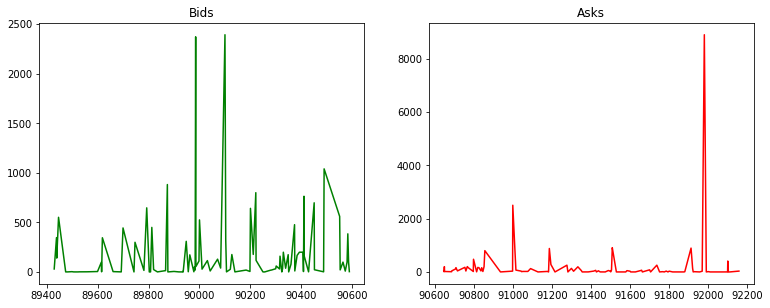

In [152]:
bid_ask_plot(binance, symbol)

In [158]:
ohlcv = exchange.fetch_ohlcv('symbol', '15m', since=1480550600000)
len(ohlcv)

BadSymbol: binance does not have market symbol BTCUSDT

In [156]:
symbol

'ETC/USDT'

In [178]:
klines_fapi_raw = binance.fapiPublic_get_klines(params={'symbol':'ETCUSDT', 'interval':'1m'})

In [180]:
klines_fapi_raw[-1]

[1579705680000,
 '9.131',
 '9.137',
 '9.124',
 '9.134',
 '709.39',
 1579705739999,
 '6478.02658',
 23,
 '390.13',
 '3562.68188',
 '0']

In [165]:
np.array(klines_fapi).astype(float)

array([[1.57967544e+12, 9.35500000e+00, 9.36100000e+00, ...,
        3.02865000e+03, 2.83415672e+04, 0.00000000e+00],
       [1.57967550e+12, 9.36000000e+00, 9.36100000e+00, ...,
        2.74256000e+03, 2.56509982e+04, 0.00000000e+00],
       [1.57967556e+12, 9.34400000e+00, 9.35600000e+00, ...,
        1.49987000e+03, 1.40206890e+04, 0.00000000e+00],
       ...,
       [1.57970526e+12, 9.11000000e+00, 9.11800000e+00, ...,
        2.90214000e+03, 2.64530111e+04, 0.00000000e+00],
       [1.57970532e+12, 9.11800000e+00, 9.13300000e+00, ...,
        5.41734000e+03, 4.94368869e+04, 0.00000000e+00],
       [1.57970538e+12, 9.11200000e+00, 9.11600000e+00, ...,
        1.35800000e+01, 1.23795280e+02, 0.00000000e+00]])

In [176]:
klines_fapi= np.array(klines_fapi).astype(float).T

In [177]:
klines_fapi.shape

(12, 500)

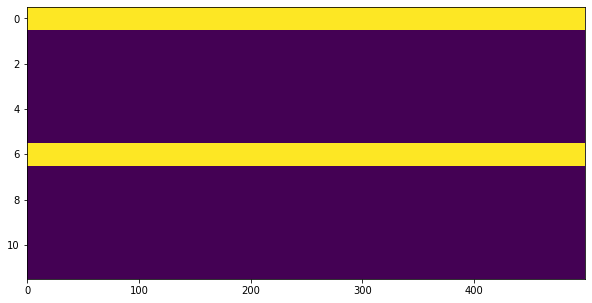

In [182]:
plt.figure(figsize=(10, 5))
plt.imshow(klines_fapi, interpolation='nearest', aspect='auto')

In [187]:
km = klines_fapi.mean(axis=1)[:, np.newaxis]
kstd = klines_fapi.std(axis=1, ddof=1)[:, np.newaxis]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


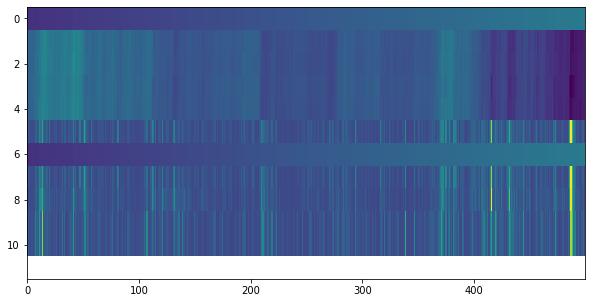

In [188]:
plt.figure(figsize=(10, 5))
plt.imshow((klines_fapi - km)/kstd, interpolation='nearest', aspect='auto')

In [198]:
pip install mpl_finance

  Created wheel for mpl-finance: filename=mpl_finance-0.10.0-py3-none-any.whl size=5509 sha256=bd5e5006354ad2e8e62e29cb75fc28281c5cc1bd8b77d084043fa9a9bdee27bb
  Stored in directory: /root/.cache/pip/wheels/93/6b/e8/7af2395634b21fd92c9ea0b8d98c7b65ff6e7930495e751a4a
Successfully built mpl-finance
Note: you may need to restart the kernel to use updated packages.


In [199]:
from mpl_finance import candlestick_ohlc

In [205]:
f = lambda x: datetime.utcfromtimestamp(x/1000).strftime('%Y-%m-%d %H:%M:%S')

In [209]:
tl = list(map(f, timeline))

In [212]:
candlestick_ohlc(timeline, klines_fapi[1:5])

AttributeError: 'numpy.ndarray' object has no attribute 'add_line'

In [217]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<Figure size 14400x7200 with 0 Axes>

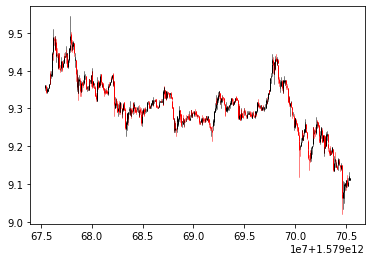

In [227]:
plt.figure(figsize=(200, 100))
fig, ax = plt.subplots()
candlestick_ohlc(ax, zip(timeline, *klines_fapi[1:5]));

['2020-01-22 06:44:00',
 '2020-01-22 06:45:00',
 '2020-01-22 06:46:00',
 '2020-01-22 06:47:00',
 '2020-01-22 06:48:00',
 '2020-01-22 06:49:00',
 '2020-01-22 06:50:00',
 '2020-01-22 06:51:00',
 '2020-01-22 06:52:00',
 '2020-01-22 06:53:00',
 '2020-01-22 06:54:00',
 '2020-01-22 06:55:00',
 '2020-01-22 06:56:00',
 '2020-01-22 06:57:00',
 '2020-01-22 06:58:00',
 '2020-01-22 06:59:00',
 '2020-01-22 07:00:00',
 '2020-01-22 07:01:00',
 '2020-01-22 07:02:00',
 '2020-01-22 07:03:00',
 '2020-01-22 07:04:00',
 '2020-01-22 07:05:00',
 '2020-01-22 07:06:00',
 '2020-01-22 07:07:00',
 '2020-01-22 07:08:00',
 '2020-01-22 07:09:00',
 '2020-01-22 07:10:00',
 '2020-01-22 07:11:00',
 '2020-01-22 07:12:00',
 '2020-01-22 07:13:00',
 '2020-01-22 07:14:00',
 '2020-01-22 07:15:00',
 '2020-01-22 07:16:00',
 '2020-01-22 07:17:00',
 '2020-01-22 07:18:00',
 '2020-01-22 07:19:00',
 '2020-01-22 07:20:00',
 '2020-01-22 07:21:00',
 '2020-01-22 07:22:00',
 '2020-01-22 07:23:00',
 '2020-01-22 07:24:00',
 '2020-01-22 07:

In [219]:
klines_fapi[:5]

array([[1.57967544e+12, 1.57967550e+12, 1.57967556e+12, ...,
        1.57970526e+12, 1.57970532e+12, 1.57970538e+12],
       [9.35500000e+00, 9.36000000e+00, 9.34400000e+00, ...,
        9.11000000e+00, 9.11800000e+00, 9.11200000e+00],
       [9.36100000e+00, 9.36100000e+00, 9.35600000e+00, ...,
        9.11800000e+00, 9.13300000e+00, 9.11600000e+00],
       [9.35000000e+00, 9.34200000e+00, 9.34200000e+00, ...,
        9.11000000e+00, 9.11200000e+00, 9.11200000e+00],
       [9.36100000e+00, 9.34400000e+00, 9.34600000e+00, ...,
        9.11800000e+00, 9.12000000e+00, 9.11600000e+00]])

In [203]:
timeline = klines_fapi[0].astype(int)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fbfc3a6ffd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fbfca713748>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fbfc3a6f390>,
 'medians': [<matplotlib.lines.Line2D at 0x7fbfca4fd940>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fbfca4fde48>,
 'means': []}

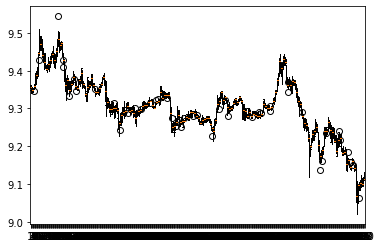

In [195]:
plt.boxplot(klines_fapi[1:5])

In [194]:
klines_fapi[1:5]

array([[9.355, 9.36 , 9.344, ..., 9.11 , 9.118, 9.112],
       [9.361, 9.361, 9.356, ..., 9.118, 9.133, 9.116],
       [9.35 , 9.342, 9.342, ..., 9.11 , 9.112, 9.112],
       [9.361, 9.344, 9.346, ..., 9.118, 9.12 , 9.116]])

In [191]:
klines_fapi_raw

[[1579675740000,
  '9.353',
  '9.355',
  '9.347',
  '9.354',
  '1451.87',
  1579675799999,
  '13578.28050',
  29,
  '952.51',
  '8909.51805',
  '0'],
 [1579675800000,
  '9.354',
  '9.366',
  '9.354',
  '9.366',
  '2471.99',
  1579675859999,
  '23134.40898',
  23,
  '2090.79',
  '19568.10388',
  '0'],
 [1579675860000,
  '9.366',
  '9.395',
  '9.366',
  '9.390',
  '9205.85',
  1579675919999,
  '86397.07924',
  94,
  '7723.24',
  '72484.50566',
  '0'],
 [1579675920000,
  '9.390',
  '9.400',
  '9.366',
  '9.378',
  '7094.11',
  1579675979999,
  '66608.70019',
  99,
  '3733.79',
  '35078.85952',
  '0'],
 [1579675980000,
  '9.386',
  '9.399',
  '9.381',
  '9.392',
  '6237.42',
  1579676039999,
  '58572.49677',
  47,
  '5040.30',
  '47334.68882',
  '0'],
 [1579676040000,
  '9.389',
  '9.410',
  '9.385',
  '9.407',
  '5174.66',
  1579676099999,
  '48631.21267',
  80,
  '2853.71',
  '26826.37655',
  '0'],
 [1579676100000,
  '9.408',
  '9.450',
  '9.386',
  '9.448',
  '20095.58',
  1579676159999

In [146]:
ohlcv

[[1528770600000, 16.2, 16.3, 15.36, 15.8499, 13411.59],
 [1528771500000, 15.8499, 15.9777, 15.4002, 15.53, 9455.97],
 [1528772400000, 15.5288, 16.7999, 15.0386, 15.15, 18421.36],
 [1528773300000, 15.1502, 15.4488, 15.1502, 15.35, 7398.61],
 [1528774200000, 15.3202, 15.6, 15.31, 15.3709, 10715.35],
 [1528775100000, 15.3703, 15.5988, 15.1445, 15.23, 11863.36],
 [1528776000000, 15.23, 15.59, 15.2, 15.4072, 8036.04],
 [1528776900000, 15.589, 15.7515, 15.4, 15.4784, 11306.49],
 [1528777800000, 15.4789, 15.6, 15.4503, 15.568, 3317.47],
 [1528778700000, 15.568, 15.7515, 15.4276, 15.6002, 8717.59],
 [1528779600000, 15.6002, 16.1501, 15.6002, 15.998, 18913.33],
 [1528780500000, 15.9979, 15.9979, 15.771, 15.943, 7482.34],
 [1528781400000, 15.943, 16.2498, 15.8991, 16.2119, 7805.61],
 [1528782300000, 16.2503, 16.3, 15.9968, 16.1502, 16611.54],
 [1528783200000, 16.2498, 16.3, 16.1, 16.1, 27170.15],
 [1528784100000, 16.1, 16.2191, 15.9089, 16.0122, 10648.61],
 [1528785000000, 15.9597, 15.96, 15.506

In [113]:
from datetime import datetime

In [143]:
print(datetime.utcfromtimestamp(1480550600000/1000).strftime('%Y-%m-%d %H:%M:%S'))


2016-12-01 00:03:20


In [9]:
print(exchange.fetch_ohlcv (symbol, '1d'))

[[1498953600000, 1.9, 1.9, 0.00070025, 0.00095799, 1309179.83712941], [1499040000000, 0.00095799, 0.0011, 0.000803, 0.000974, 574764.36761537], [1499126400000, 0.00097201, 0.00099177, 0.0008311, 0.00088005, 276558.28770952], [1499212800000, 0.00088005, 0.00089096, 0.000708, 0.000732, 252578.23549845], [1499299200000, 0.000732, 0.0007877, 0.00069, 0.000749, 168446.97038139], [1499385600000, 0.00074901, 0.00075, 0.00054366, 0.00057415, 162383.33245124], [1499472000000, 0.0005759, 0.00064, 0.0005, 0.00053, 132111.35839329], [1499558400000, 0.00053238, 0.00058667, 0.0005, 0.00057, 102256.13086699], [1499644800000, 0.00057, 0.0005719, 0.00039488, 0.00041002, 206886.17339539], [1499731200000, 0.00041007, 0.00041853, 0.00032096, 0.00036331, 164805.71534074], [1499817600000, 0.00037025, 0.00043965, 0.00036402, 0.00041532, 95663.34986954], [1499904000000, 0.0004245, 0.000435, 0.00037758, 0.00037758, 54491.72963433], [1499990400000, 0.00038, 0.00039409, 0.00035037, 0.0003562, 68734.93272246], [1

In [23]:
bids[:, 1]

array([1.41882367e+04, 1.81762444e+04, 3.02886508e+04, 5.83864244e+04,
       1.12964735e+05, 1.14024976e+05, 1.32433659e+05, 1.11316340e+04,
       6.90074827e+04, 4.47336833e+04, 1.40510837e+05, 2.99268991e+05,
       1.89314928e+03, 6.60109938e+02, 9.64400609e+04, 8.61519743e+04,
       9.09090972e+04, 2.53411155e+04, 1.95093733e+04, 6.13556149e+04,
       3.67851588e+05, 1.94453661e+05, 2.44560292e+05, 1.74995257e+05,
       2.45878447e+05, 1.98880116e+05, 3.72262528e+05, 4.68796887e+04,
       6.72657479e+03, 6.76432177e+04, 1.82904012e+05, 3.14162655e+05,
       2.61698419e+04, 2.32735122e+04, 7.69322110e+04, 3.35475060e+05,
       2.26332835e+05, 1.25439361e+02, 2.84275109e+02, 2.94588987e+05,
       1.17547502e+05, 5.42215686e+04, 8.00341861e+03, 9.40690012e+04,
       8.22509942e+04, 2.12434609e+05, 4.81131624e+05, 7.95283205e+04,
       2.38973622e+05, 3.14425546e+04, 1.29612531e+05, 6.16611235e+05,
       1.63093761e+04, 9.09543768e+04, 2.24164635e+04, 1.05235696e+05,
      

In [8]:
bittrex.

dict_keys(['LTC/BTC', 'DOGE/BTC', 'VTC/BTC', 'PPC/BTC', 'FTC/BTC', 'RDD/BTC', 'NXT/BTC', 'DASH/BTC', 'POT/BTC', 'BLK/BTC', 'EMC2/BTC', 'XMY/BTC', 'GLC/BTC', 'SLR/BTC', 'GRS/BTC', 'NLG/BTC', 'XWC/BTC', 'MONA/BTC', 'THC/BTC', 'VRC/BTC', 'CURE/BTC', 'XMR/BTC', 'CLOAK/BTC', 'KORE/BTC', 'XDN/BTC', 'NAV/BTC', 'XST/BTC', 'VIA/BTC', 'PINK/BTC', 'IOC/BTC', 'SYS/BTC', 'NEOS/BTC', 'DGB/BTC', 'BURST/BTC', 'EXCL/BTC', 'BLOCK/BTC', 'ABY/BTC', 'BAY/BTC', 'BTS/BTC', 'XRP/BTC', 'GAME/BTC', 'NXS/BTC', 'BITB/BTC', 'GEO/BTC', 'FLDC/BTC', 'GRC/BTC', 'FLO/BTC', 'MUE/BTC', 'XEM/BTC', 'DMD/BTC', 'SPHR/BTC', 'OK/BTC', 'AEON/BTC', 'ETH/BTC', 'TX/BTC', 'EXP/BTC', 'AMP/BTC', 'XLM/BTC', 'BTC/USDT', 'RVR/BTC', 'EMC/BTC', 'FCT/BTC', 'MAID/BTC', 'SLS/BTC', 'RADS/BTC', 'DCR/BTC', 'BSD/BTC', 'XVG/BTC', 'PIVX/BTC', 'MEME/BTC', 'STEEM/BTC', 'LSK/BTC', 'DGD/BTC', 'WAVES/BTC', 'LBC/BTC', 'SBD/BTC', 'ETC/BTC', 'ETC/ETH', 'STRAT/BTC', 'SYNX/BTC', 'SEQ/BTC', 'REP/BTC', 'SHIFT/BTC', 'ARDR/BTC', 'XZC/BTC', 'NEO/BTC', 'ZEC/BTC',

In [5]:
yobit.fetch_balance()

{'info': {'rights': {'info': 1, 'trade': 1, 'deposit': 1, 'withdraw': 1},
  'transaction_count': 0,
  'open_orders': 0,
  'server_time': 1557479051},
 'free': {},
 'used': {},
 'total': {}}

In [9]:
print(yobit.fetch_trades('BTC/USD'))

[{'id': '203395474', 'order': None, 'timestamp': 1557477574000, 'datetime': '2019-05-10T08:39:34.000Z', 'symbol': 'BTC/USD', 'type': 'limit', 'side': 'buy', 'takerOrMaker': None, 'price': 6281.0973, 'amount': 0.11708145, 'fee': None, 'info': {'type': 'bid', 'price': 6281.0973, 'amount': 0.11708145, 'tid': 203395474, 'timestamp': 1557477574}}, {'id': '203395473', 'order': None, 'timestamp': 1557477574000, 'datetime': '2019-05-10T08:39:34.000Z', 'symbol': 'BTC/USD', 'type': 'limit', 'side': 'buy', 'takerOrMaker': None, 'price': 6280.1422, 'amount': 0.15160485, 'fee': None, 'info': {'type': 'bid', 'price': 6280.1422, 'amount': 0.15160485, 'tid': 203395473, 'timestamp': 1557477574}}, {'id': '203395472', 'order': None, 'timestamp': 1557477574000, 'datetime': '2019-05-10T08:39:34.000Z', 'symbol': 'BTC/USD', 'type': 'limit', 'side': 'buy', 'takerOrMaker': None, 'price': 6280.134, 'amount': 0.07947282, 'fee': None, 'info': {'type': 'bid', 'price': 6280.134, 'amount': 0.07947282, 'tid': 2033954